# Introduction to Sentiment Analysis

This notebook provides a thorough introduction to the concept of sentiment analysis in particular and NLP embeddings in general.

## Setup libraries and functions.

We start by importing various libraries needed.

In [1]:
# Plots displayed inline in notebook
%matplotlib inline

# Make Python 3 consistent
from __future__ import print_function, division

# Make help libraries available
import sys

sys.path.append('/home/ubuntu/personal-libraries')
sys.path.append('deep-learning/embedding-intro')

In [73]:
from kerastools.utils import load_array
from tsne.tsne import tsne

import numpy as np
import pickle
import os
import re

from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from numpy.random import normal

from keras.datasets import imdb
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, Input
from keras.layers.convolutional import Conv1D
from keras.layers.embeddings import Embedding
from keras.layers.merge import concatenate
from keras.layers import SpatialDropout1D
from keras.layers.pooling import MaxPooling1D
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.utils import get_file

from keras import backend as K
K.set_image_data_format('channels_first')

In [3]:
model_path = 'models/sentiment-analysis-intro/'

## Setup data

We're going to look at the IMDB dataset, which contains movie reviews from IMDB, along with their sentiment. Keras comes with some helpers for this dataset.

In [4]:
idx = imdb.get_word_index()

This is the word list:

In [5]:
idx_arr = sorted(idx, key=idx.get)
idx_arr[:10]

[u'the', u'and', u'a', u'of', u'to', u'is', u'br', u'in', u'it', u'i']

...and this is the mapping from id to word

In [6]:
idx2word = {v: k for k, v in idx.iteritems()}

In order to the data in the purest form, we download the reviews using code copied from keras.datasets:

In [7]:
path = get_file('imdb_full.pkl',
                origin = 'https://s3.amazonaws.com/text-datasets/imdb_full.pkl',
                md5_hash = 'd091312047c43cf9e4e38fef92437263')
f = open(path, 'rb')
(x_train, labels_train), (x_test, labels_test) = pickle.load(f)

In [8]:
len(x_train)

25000

Here's the 1st review. As you see, the words have been replaced by ids. The ids can be looked up in idx2word.

In [9]:
', '.join(map(str, x_train[0]))

'23022, 309, 6, 3, 1069, 209, 9, 2175, 30, 1, 169, 55, 14, 46, 82, 5869, 41, 393, 110, 138, 14, 5359, 58, 4477, 150, 8, 1, 5032, 5948, 482, 69, 5, 261, 12, 23022, 73935, 2003, 6, 73, 2436, 5, 632, 71, 6, 5359, 1, 25279, 5, 2004, 10471, 1, 5941, 1534, 34, 67, 64, 205, 140, 65, 1232, 63526, 21145, 1, 49265, 4, 1, 223, 901, 29, 3024, 69, 4, 1, 5863, 10, 694, 2, 65, 1534, 51, 10, 216, 1, 387, 8, 60, 3, 1472, 3724, 802, 5, 3521, 177, 1, 393, 10, 1238, 14030, 30, 309, 3, 353, 344, 2989, 143, 130, 5, 7804, 28, 4, 126, 5359, 1472, 2375, 5, 23022, 309, 10, 532, 12, 108, 1470, 4, 58, 556, 101, 12, 23022, 309, 6, 227, 4187, 48, 3, 2237, 12, 9, 215'

The first word of the first review is 23022. Let's see what that is.

In [10]:
idx2word[23022]

u'bromwell'

Here's the whole review, mapped from ids to words.

In [11]:
' '.join([idx2word[o] for o in x_train[0]])

u"bromwell high is a cartoon comedy it ran at the same time as some other programs about school life such as teachers my 35 years in the teaching profession lead me to believe that bromwell high's satire is much closer to reality than is teachers the scramble to survive financially the insightful students who can see right through their pathetic teachers' pomp the pettiness of the whole situation all remind me of the schools i knew and their students when i saw the episode in which a student repeatedly tried to burn down the school i immediately recalled at high a classic line inspector i'm here to sack one of your teachers student welcome to bromwell high i expect that many adults of my age think that bromwell high is far fetched what a pity that it isn't"

The labels are 1 for positive, 0 for negative.

In [12]:
labels_train[:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Reduce vocab size by setting rare words to max index. This index will represent a word, which semantics won't matter. The word will simply represent "rare word".

In [13]:
vocab_size = 5000

trn = [np.array([i if i < vocab_size - 1 else vocab_size - 1 for i in s]) for s in x_train]
test = [np.array([i if i < vocab_size - 1 else vocab_size - 1 for i in s]) for s in x_test]

Look at distribution of lengths of sentences.

In [14]:
lens = np.array(map(len, trn))
(lens.max(), lens.min(), lens.mean())

(2493, 10, 237.71364)

Pad (with zero) or truncate each sentence to make consistent length. I.e. make such that each review has the same length. We can do this using the pad_sequences preprocessing function from Keras. Thus the reviews get patted from the front (left). We use 0s.

In [15]:
seq_len = 500

trn = sequence.pad_sequences(trn, maxlen = seq_len, value = 0)
test = sequence.pad_sequences(test, maxlen = seq_len, value = 0)

This results in nice rectangular matrices that can be passed to ML algorithms. Reviews shorter than 500 words are pre-padded with zeros, those greater are truncated.

In [16]:
trn.shape

(25000, 500)

## Create simple models

### Single hidden layer NN

The simplest model that tends to give reasonable results is a single hidden layer net. So let's try that. Note that we can't expect to get any useful results by feeding word ids directly into a neural net - so instead we use an embedding to replace them with a vector of 32 (initially random) floats for each word in the vocab.

So our input is a word id, which we want to convert to a vector. Rather than one hot encode it and get a 5000 length vector, we use an embedding with 5000 latent factors with 32 items.

We use 32 as output layers. As a rule of thumb states that 50 dimensions is enough to capture a vocabulary of 100,000. Thus 32 should be more than enoch to capture a vocabulary of 5000 words. 32 take the role of channels here (so 32 instead of 3).

So our input is 25000 sequences of 500 integers. So we take each integer and replace them with a look up to a 500 column matrix. (500x32). This matrix is initially random, and will be optimized using the gradient descent algorithm of Excel.

Note that we use the sigmoid actiavationa s the final activation. This enables us to simply use a one dimensional input, i.e. one vector with either 0 or 1 values. If we wanted to use softmax, which would be perfectly applicable as well, we would have to one hot encode the input.

In [33]:
model = Sequential([
    Embedding(vocab_size, 32, input_length = seq_len),
    Flatten(),
    Dense(100, activation = 'relu'),
    Dropout(0.7),
    Dense(1, activation = 'sigmoid')])

In [36]:
model.compile(loss = 'binary_crossentropy', optimizer = Adam(), metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               1600100   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 1,760,201
Trainable params: 1,760,201
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.fit(trn,
          labels_train,
          epochs = 2,
          batch_size = 64,
          validation_data=(test, labels_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 6s - loss: 0.4478 - acc: 0.7629 - val_loss: 0.2839 - val_acc: 0.8798
Epoch 2/2
25000/25000 [==============================] - 6s - loss: 0.1971 - acc: 0.9282 - val_loss: 0.3076 - val_acc: 0.8696


The [stanford paper](http://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf) that this dataset is from cites a state of the art accuracy (without unlabelled data) of 0.883. So we're short of that, but on the right track.

### Single conv layer with max pooling

A CNN is likely to work better, since it's designed to take advantage of ordered data. We'll need to use a 1D CNN, since a sequence of words is 1D.

In [60]:
conv1 = Sequential([
    Embedding(vocab_size, 32, input_length = seq_len),
    # The `dropout` argument is no longer support in `Embedding`. One 
    # can apply a `keras.layers.SpatialDropout1D` layer right after the
    # `Embedding` layer to get the same behavior.
    # This dropout zeroes out at random 20% of each of the 32 embeddings for each word.
    # So it is avoiding overfitting the specifics of each words embedding.
    SpatialDropout1D(0.2),
    # This dropout removes 20% of each word. That is 20% of the entire embeddings.
    Dropout(0.2),
    Conv1D(64, 5, padding = 'same', activation = 'relu'),
    Dropout(0.2),
    MaxPooling1D(),
    Flatten(),
    Dense(100, activation = 'relu'),
    Dropout(0.7),
    Dense(1, activation = 'sigmoid')])

In [61]:
conv1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 500, 32)           0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 500, 32)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 500, 64)           10304     
_________________________________________________________________
dropout_19 (Dropout)         (None, 500, 64)           0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 250, 64)           0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 16000)             0         
__________

The model is initialised, so now we compile it.

In [62]:
conv1.compile(loss = 'binary_crossentropy', optimizer = Adam(), metrics = ['accuracy'])

And then we train it.

In [63]:
conv1.fit(trn,
          labels_train,
          epochs = 4,
          batch_size = 64,
          validation_data = (test, labels_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 20s - loss: 0.5477 - acc: 0.6706 - val_loss: 0.2819 - val_acc: 0.8870
Epoch 2/4
25000/25000 [==============================] - 20s - loss: 0.2811 - acc: 0.8969 - val_loss: 0.2576 - val_acc: 0.8936
Epoch 3/4
25000/25000 [==============================] - 20s - loss: 0.2235 - acc: 0.9184 - val_loss: 0.2698 - val_acc: 0.8885
Epoch 4/4
25000/25000 [==============================] - 20s - loss: 0.1964 - acc: 0.9296 - val_loss: 0.2731 - val_acc: 0.8900


That's well past the Stanford paper's accuracy - another win for CNNs!

In [64]:
conv1.save_weights(model_path + 'conv1.h5')

In [65]:
conv1.load_weights(model_path + 'conv1.h5')

## Pre-trained vectors

Each word embedding should represent the meaning of each word. This can be hard to extract, when using a small dataset. Instead we can use pretrained embeddings, where each word embedding a result of training on a much larger dataset.

One such pretrained embedding is Glove or Word2Vec.

You may want to look at wordvectors.ipynb before moving on.

In this section, we replicate the previous CNN, but using pre-trained embeddings.

Define a function to get the Glove dataset.

In [54]:
def get_glove_dataset(dataset):
    """Download the requested glove dataset from files.fast.ai
    and return a location that can be passed to load_vectors.
    """
    # see wordvectors.ipynb for info on how these files were
    # generated from the original glove data.
    md5sums = {'6B.50d': '8e1557d1228decbda7db6dfd81cd9909',
               '6B.100d': 'c92dbbeacde2b0384a43014885a60b2c',
               '6B.200d': 'af271b46c04b0b2e41a84d8cd806178d',
               '6B.300d': '30290210376887dcc6d0a5a6374d8255'}
    glove_path = os.path.abspath('data/glove')
    return get_file(dataset,
                    'http://files.fast.ai/models/glove/' + dataset + '.tgz',
                    cache_subdir = glove_path,
                    md5_hash = md5sums.get(dataset, None),
                    untar = True)

In [55]:
def load_vectors(loc):
    return (load_array(loc + '.dat'),
        pickle.load(open(loc + '_words.pkl','rb')),
        pickle.load(open(loc + '_idx.pkl','rb')))

So we load the Glove word vectors, giving us the embeddings (vecs), that is the 400,000x50 word vectors (so we use an output dimension of 50 in this case). A list of the words (words). And finally a ist of the word indexes (wordidx).

In [56]:
vecs, words, wordidx = load_vectors(get_glove_dataset('6B.50d'))

We can consider the shape of the word vectors, which is as expected.

In [20]:
vecs.shape

(400000, 50)

We can consider the first 25 words in the words list.

In [21]:
' '.join(words[:25])

'the , . of to and in a " \'s for - that on is was said with he as it by at ( )'

For looking up the words vectors based on indesies, we can define a function.

In [22]:
def w2v(w): return vecs[wordidx[w]]

We can then look up a sample word.

In [23]:
w2v('of')

array([ 0.70853001,  0.57088   , -0.4716    ,  0.18048   ,  0.54448998,
        0.72602999,  0.18156999, -0.52393001,  0.10381   , -0.17566   ,
        0.078852  , -0.36216   , -0.11829   , -0.83336002,  0.11917   ,
       -0.16605   ,  0.061555  , -0.012719  , -0.56623   ,  0.013616  ,
        0.22851001, -0.14396   , -0.067549  , -0.38157001, -0.23698001,
       -1.70369995, -0.86691999, -0.26704001, -0.25889999,  0.1767    ,
        3.86759996, -0.1613    , -0.13273001, -0.68880999,  0.18444   ,
        0.0052464 , -0.33873999, -0.078956  ,  0.24185   ,  0.36576   ,
       -0.34727001,  0.28483   ,  0.075693  , -0.062178  , -0.38988   ,
        0.22902   , -0.21617   , -0.22562   , -0.093918  , -0.80374998], dtype=float32)

We can also try an visualise the words. To do that, we need to reduce the dimensionality of the 50 dimensional embedding. We do this using T-SNE, reducing the dimensionality to two. We do this on the 350 most common words.

Rather than using the sklearn method, which kills the kernel for some reason, we use the origianl implementation by [Laurens Van Der Maaten](https://lvdmaaten.github.io/tsne/code/tsne_python.zip).

We can then plot the words on the two dimensions. Note how similar words group together. For instance punctuation, (dollars, million, $), (university, school), etc.

Note that we also loose a lot of information on each word, by reducing the dimensionality. Thus the meaning of a word is far more complex, than what a human can visualise and see in two dimensions.

In [27]:
Y = tsne(vecs[:500], no_dims = 2, initial_dims = 50)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  500 ...
Mean value of sigma:  1.3839218119
Iteration  10 : error is  15.6590294697
Iteration  20 : error is  15.0989135708
Iteration  30 : error is  14.9989455956
Iteration  40 : error is  15.2739429287
Iteration  50 : error is  15.2810067212
Iteration  60 : error is  15.4257411279
Iteration  70 : error is  15.2925993078
Iteration  80 : error is  15.5838872148
Iteration  90 : error is  15.503726118
Iteration  100 : error is  15.6088414445
Iteration  110 : error is  1.69846384483
Iteration  120 : error is  1.29840710017
Iteration  130 : error is  1.15163541784
Iteration  140 : error is  1.06123571701
Iteration  150 : error is  0.996619899177
Iteration  160 : error is  0.971691256795
Iteration  170 : error is  0.959125845408
Iteration  180 : error is  0.950984380655
Iteration  190 : error is  0.945105411804
Iteration  200 : error is  0.940732631956
Iteration  210 : error is  0.9372000

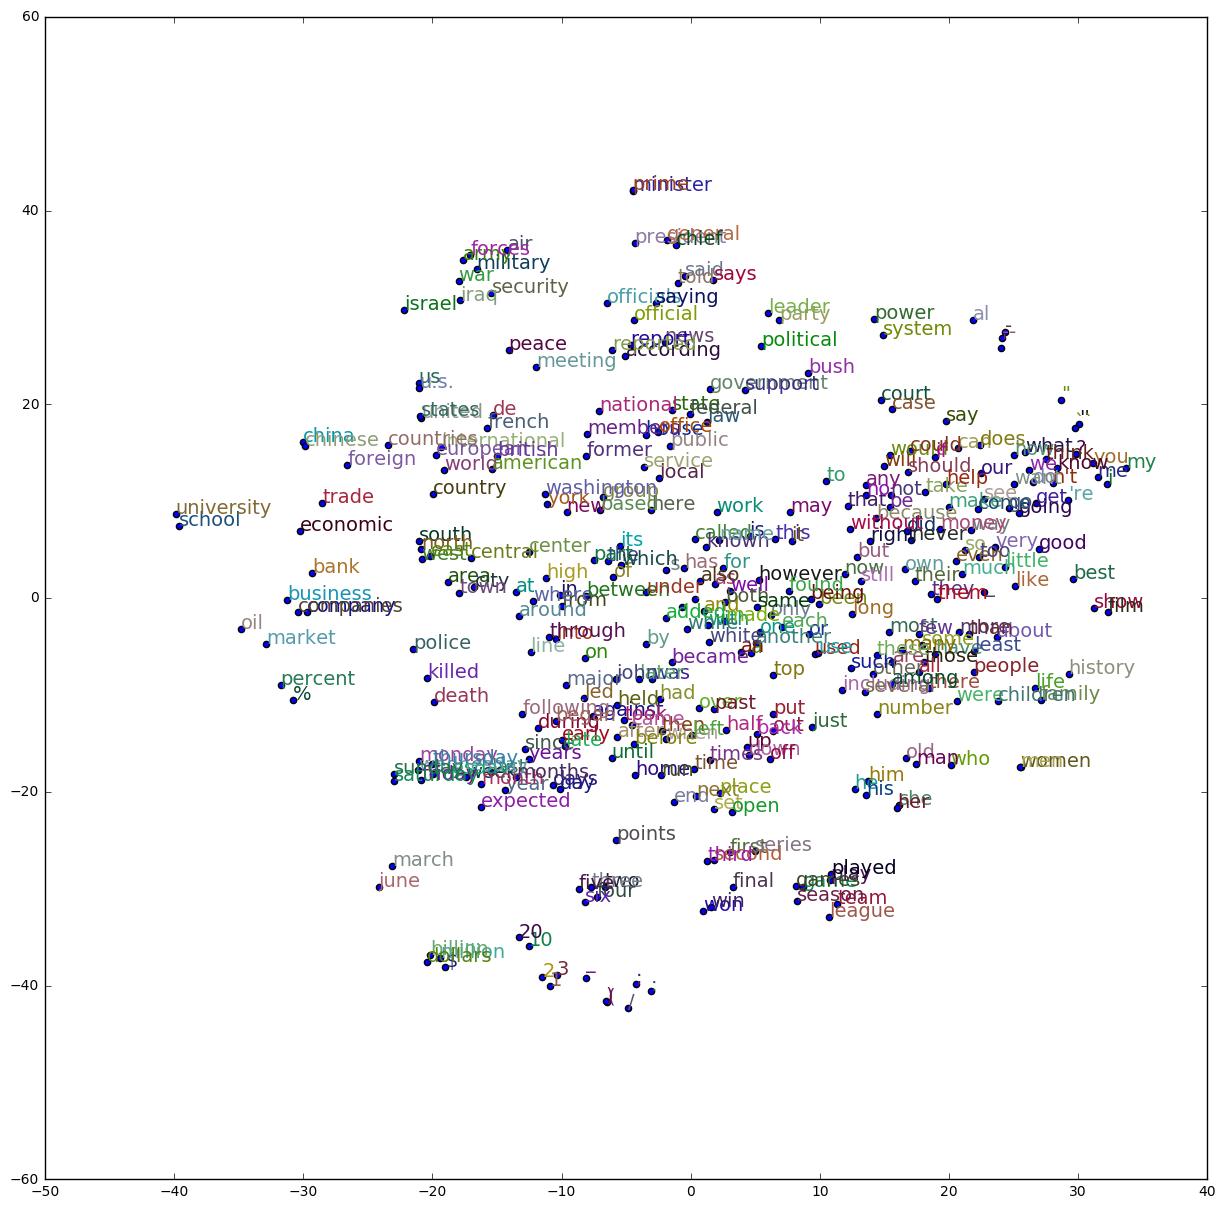

In [28]:
start = 0
end = 350

dat = Y[start:end]
plt.figure(figsize = (15, 15))
plt.scatter(dat[:, 0], dat[:, 1])

for label, x, y in zip(words[start:end], dat[:, 0], dat[:, 1]):
    plt.text(x, y, label.decode('utf-8'), color = np.random.rand(3) * 0.7 ,
                 fontsize = 14)
plt.show()

The glove word ids and imdb word ids use different indexes. So we create a simple function that creates an embedding matrix using the indexes from imdb, and the embeddings from glove (where they exist).

In [57]:
def create_emb():
    n_fact = vecs.shape[1]
    emb = np.zeros((vocab_size, n_fact))

    for i in range(1,len(emb)):
        word = idx2word[i]
        if word and re.match(r"^[a-zA-Z0-9\-]*$", word):
            src_idx = wordidx[word]
            emb[i] = vecs[src_idx]
        else:
            # If we can't find the word in glove, randomly initialize
            emb[i] = normal(scale = 0.6, size=(n_fact,))

    # This is our "rare word" id - we want to randomly initialize
    emb[-1] = normal(scale = 0.6, size = (n_fact,))
    emb /= 3
    return emb

We can then create the embedding

In [58]:
emb = create_emb()

We pass our embedding matrix to the Embedding constructor, and set it to non-trainable. We do this bacuase we believe the pre trained embeddings to be retty good.

However, we won't leave them un trained, we will fine tune them. Why? Consider the function above. Sometimes we try and look up a word in Glove, which it does not contain. We then simply use a random weights. We have to fine tune the pre trained embedding in order to train these random weights.

This turned out not to be the case for me. To get any descent sort of results. The embedding layers had to be trainable from the start!

In [68]:
model = Sequential([
    Embedding(vocab_size, 50, input_length = seq_len, 
              weights = [emb], trainable = True),
    # The `dropout` argument is no longer support in `Embedding`. One 
    # can apply a `keras.layers.SpatialDropout1D` layer right after the
    # `Embedding` layer to get the same behavior.
    # This dropout zeroes out at random 20% of each of the 32 embeddings for each word.
    # So it is avoiding overfitting the specifics of each words embedding.
    SpatialDropout1D(0.2),
    # This dropout removes 25% of each word. That is 25% of the entire embeddings.
    Dropout(0.25),
    Conv1D(64, 5, padding = 'same', activation = 'relu'),
    Dropout(0.25),
    MaxPooling1D(),
    Flatten(),
    Dense(100, activation = 'relu'),
    Dropout(0.7),
    Dense(1, activation = 'sigmoid')])

In [69]:
model.compile(loss = 'binary_crossentropy', optimizer = Adam(), metrics = ['accuracy'])

Train the model for a few epochs.

In [70]:
model.fit(trn, labels_train,
          epochs = 4,
          batch_size = 64,
          validation_data = (test, labels_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 22s - loss: 0.5860 - acc: 0.6635 - val_loss: 0.3209 - val_acc: 0.8635
Epoch 2/4
25000/25000 [==============================] - 21s - loss: 0.3296 - acc: 0.8697 - val_loss: 0.2621 - val_acc: 0.8957
Epoch 3/4
25000/25000 [==============================] - 21s - loss: 0.2595 - acc: 0.8995 - val_loss: 0.2554 - val_acc: 0.8945
Epoch 4/4
25000/25000 [==============================] - 21s - loss: 0.2268 - acc: 0.9129 - val_loss: 0.2441 - val_acc: 0.9002


We do see major improvement over state of the art, so we save the weights here.

Jeremy experimented with first setting the embedding as untrainable and then training them afterwards. I got very bad results doing that. The best approch was just to train all the layers at the same time for me.

In [71]:
model.save_weights(model_path + 'glove50.h5')

## Multi-size CNN

This is an implementation of a multi-size CNN as shown in Ben Bowles' [excellent blog post](https://quid.com/feed/how-quid-uses-deep-learning-with-small-data).

We use the functional API to create multiple conv layers of different sizes, and then concatenate them.

In [75]:
graph_in = Input ((vocab_size, 50))
convs = [ ] 
for fsz in range (3, 6): 
    x = Conv1D(64, fsz, padding = 'same', activation = "relu")(graph_in)
    x = MaxPooling1D()(x) 
    x = Flatten()(x) 
    convs.append(x)
    
# So this is the point. We concatenate all the layers instead of letting
# them feed into each other.
out = concatenate(convs)
graph = Model(graph_in, out) 

In [76]:
emb = create_emb()

We then replace the conv/max-pool layer in our original CNN with the concatenated conv layers.

In [85]:
model = Sequential ([
    Embedding(vocab_size, 50, input_length = seq_len, weights = [emb]),
    SpatialDropout1D(0.2),
    Dropout (0.2),
    graph,
    Dropout (0.5),
    Dense (100, activation = "relu"),
    Dropout (0.7),
    Dense (1, activation = 'sigmoid')
    ])

In [86]:
model.compile(loss = 'binary_crossentropy', optimizer = Adam(), metrics = ['accuracy'])

In [87]:
model.fit(trn,
          labels_train,
          epochs = 2,
          batch_size = 64,
          validation_data = (test, labels_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 38s - loss: 0.4362 - acc: 0.7955 - val_loss: 0.3069 - val_acc: 0.8742
Epoch 2/2
25000/25000 [==============================] - 38s - loss: 0.2920 - acc: 0.8824 - val_loss: 0.2622 - val_acc: 0.8978


Interestingly, I found that in this case I got best results when I started the embedding layer as being trainable, and then set it to non-trainable after a couple of epochs. I have no idea why! (Note, thise is Jeremy. I experienced the same with the simpler model.)

In [88]:
model.layers[0].trainable = False

In [89]:
model.optimizer.lr = 1e-4

model.fit(trn,
          labels_train,
          epochs = 4,
          batch_size = 64,
          validation_data = (test, labels_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 39s - loss: 0.2482 - acc: 0.9002 - val_loss: 0.2512 - val_acc: 0.8991
Epoch 2/4
25000/25000 [==============================] - 38s - loss: 0.2176 - acc: 0.9156 - val_loss: 0.2478 - val_acc: 0.8991
Epoch 3/4
25000/25000 [==============================] - 38s - loss: 0.1957 - acc: 0.9248 - val_loss: 0.2645 - val_acc: 0.8918
Epoch 4/4
25000/25000 [==============================] - 38s - loss: 0.1759 - acc: 0.9328 - val_loss: 0.2569 - val_acc: 0.8980


This more complex architecture could give us another boost in accuracy.

## LSTM

We haven't covered this bit yet!

In [79]:
model = Sequential([
    Embedding(vocab_size, 32, input_length=seq_len, mask_zero=True,
              W_regularizer=l2(1e-6), dropout=0.2),
    LSTM(100, consume_less='gpu'),
    Dense(1, activation='sigmoid')])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_13 (Embedding)         (None, 500, 32)       160064      embedding_input_13[0][0]         
____________________________________________________________________________________________________
lstm_13 (LSTM)                   (None, 100)           53200       embedding_13[0][0]               
____________________________________________________________________________________________________
dense_18 (Dense)                 (None, 1)             101         lstm_13[0][0]                    
Total params: 213365
____________________________________________________________________________________________________


In [80]:
model.fit(trn, labels_train, validation_data=(test, labels_test), nb_epoch=5, batch_size=64)

Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 100s - loss: 0.5007 - acc: 0.7446 - val_loss: 0.3475 - val_acc: 0.8531
Epoch 2/5
25000/25000 [==============================] - 100s - loss: 0.3524 - acc: 0.8507 - val_loss: 0.3602 - val_acc: 0.8453
Epoch 3/5
25000/25000 [==============================] - 99s - loss: 0.3750 - acc: 0.8342 - val_loss: 0.4758 - val_acc: 0.7710
Epoch 4/5
25000/25000 [==============================] - 99s - loss: 0.3238 - acc: 0.8652 - val_loss: 0.3094 - val_acc: 0.8725
Epoch 5/5
25000/25000 [==============================] - 99s - loss: 0.2681 - acc: 0.8920 - val_loss: 0.3018 - val_acc: 0.8776
